# Song recommender

In [2]:
import pandas as pd
import numpy as np
import scraping as sc
import helper_functions as hf
import data_handler as dh
import spotifyhandler as sh
import spotipy
import pickle
from tqdm.auto import tqdm
import modelling

from matplotlib import pyplot
from sklearn.metrics import silhouette_score

In [10]:
# Run Marker
update_bb_top100 = False
update_wiki_artist = False
update_song_list = False
update_audio_features = False
create_words_list = False

In [11]:
# Load existing files


In [12]:
#sc.recommend_song()

In [13]:
if update_wiki_artist:
    artist_Series = sc.load_or_scrape('wiki_artist')['artists']
    artist_list = list(artist_Series)

In [14]:
if update_song_list:
    song_list = sh.search_songs(artist_list)
    len(song_list)

In [15]:
if create_words_list:
    print('create words list')
    words_list = hf.txt_to_list('data/speeches.txt')
    len(words_list)

In [16]:
if create_words_list:    
    song_list_update = sh.search_songs(words_list)
    len(song_list_update)


In [17]:
## concat multiple csvs and concat it to original df
if update_audio_features:
    df_complete_update = dh.concat_csvs('audio_features_update',25)
    df_complete_update.shape
    dh.update_audiofeatures_csv(df_complete_update)

### Load audiofeatures csv into df

In [3]:
df_audiofeatures = pd.read_csv('data/audio_features.csv')
print(df_audiofeatures.shape)
df_audiofeatures.head(3)

(275081, 20)


,artists,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Wings,Mull Of Kintyre - Remastered 1993,0.350,0.297,2,-13.781,1,0.0265,0.000285,0.0000,0.123,0.423,90.603,audio_features,5yrgufPBA1PqSIOHZHrkYa,spotify:track:5yrgufPBA1PqSIOHZHrkYa,https://api.spotify.com/v1/tracks/5yrgufPBA1Pq...,https://api.spotify.com/v1/audio-analysis/5yrg...,282533,3
1,Ben Folds Five,"Selfless, Cold and Composed",0.233,0.497,11,-9.508,1,0.0322,0.361000,0.0288,0.076,0.272,180.779,audio_features,43Fd2LMelrD0HU01n4g4cw,spotify:track:43Fd2LMelrD0HU01n4g4cw,https://api.spotify.com/v1/tracks/43Fd2LMelrD0...,https://api.spotify.com/v1/audio-analysis/43Fd...,370347,3
2,Jimmy Cliff,Give And Take,0.833,0.559,2,-13.320,1,0.0688,0.087000,0.0000,0.333,0.652,127.907,audio_features,2YYtbzCV6jKwemSv6JoI8R,spotify:track:2YYtbzCV6jKwemSv6JoI8R,https://api.spotify.com/v1/tracks/2YYtbzCV6jKw...,https://api.spotify.com/v1/audio-analysis/2YYt...,133333,4


### Train scaler on audiofeatures df

In [4]:
# first strip of df of unessessary columns
X = modelling.to_feature_df(df_audiofeatures)

# fit scaler to df
scaler = modelling.fit_scaler(X)

# transform df
X_scaled = modelling.scale(X)

In [5]:
X_scaled

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,-1.130726,-1.078000,-0.899409,-0.543956,0.781120,-0.604004,-0.946965,-0.663998,-0.431924,-0.082216,-0.971861,-1.832825
1,-1.739514,-0.329172,1.601013,0.105594,0.781120,-0.564848,0.099809,-0.586119,-0.704073,-0.660887,2.001236,-1.832825
2,1.382475,-0.097035,-0.899409,-0.473878,0.781120,-0.313422,-0.695323,-0.663998,0.784062,0.795370,0.258050,0.215020
3,0.825720,0.790327,-0.065935,0.965227,-1.280213,-0.277013,-0.692712,-0.663998,-0.587686,1.623137,-0.332013,0.215020
4,0.674824,1.052417,-1.455059,0.390770,0.781120,-0.542865,-0.347090,-0.663998,-0.823934,1.554156,0.267215,0.215020
...,...,...,...,...,...,...,...,...,...,...,...,...
275076,0.518724,0.917628,1.601013,0.605717,0.781120,-0.573778,-0.722311,-0.663968,-0.460876,0.818363,-0.655844,0.215020
275077,0.367828,-1.456159,1.601013,-2.159092,0.781120,1.583949,-0.088818,-0.663998,-0.732446,-0.511429,0.676537,2.262865
275078,0.008799,1.044929,-1.177234,0.682027,-1.280213,-0.556604,-0.416737,1.045021,-0.635167,-0.664719,-0.562704,0.215020
275079,-1.359672,-0.857096,-1.455059,0.224468,0.781120,-0.595761,1.579799,-0.663998,2.920724,-1.247222,0.665525,0.215020


### Train Model on audiofeatures df

In [6]:
kmeans = modelling.train_kmeans(X_scaled, number_clusters=12)

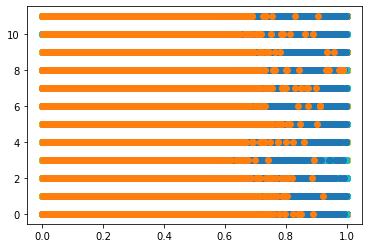

In [7]:
# assign a cluster to each example
labels = kmeans.predict(X_scaled)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(X.to_numpy()[row_ix, 1], X.to_numpy()[row_ix, 2])
    # show the plot
pyplot.show()